In [1]:
import pathlib
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import google

matplotlib.rcParams.update({
    'figure.dpi': 150,
    'font.size': 8,
})


In [2]:
def fixup_dataframe(df, exp_id, test=False):
    for col in df.columns:
    # We need to rename
    # Rename successRate for ML10/45 (average training success rate over all tasks for ML)
        if exp_id.startswith('rl2'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
            df.rename(columns={'MetaTest/Average/SuccessRate': 'TestSuccessRate'}, inplace=True)
        elif exp_id.startswith('maml'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
            df.rename(columns={'MetaTest/Average/SuccessRate': 'TestSuccessRate'}, inplace=True)
            # Fix -1 in success rate
            df[df.filter(regex='SuccessRate').columns].applymap(lambda x: np.nan if x == -1 else x)
        elif exp_id.startswith('mtsac'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
        elif exp_id.startswith('mttrpo'):
            df.rename(columns={'Evaluation/SuccessRate': 'SuccessRate'}, inplace=True)
        elif exp_id.startswith('mtppo'):
            df.rename(columns={'Evaluation/SuccessRate': 'SuccessRate'}, inplace=True)

    # Multiply by 100 for 100%
    if "SuccessRate" in df.columns:
        df['SuccessRate'] = df['SuccessRate'].apply(lambda x: 100.0 * x)
    if 'TestSuccessRate' in df.columns:
        df['TestSuccessRate'] = df['TestSuccessRate'].apply(lambda x: 100.0 * x)
    return df

# ML1 Push, Pick-Place RL2

In [10]:
experiment_data=[
    'maml_trpo_metaworld_mt10_seed=1312_il=0.05_extra_tags=none',
    'maml_trpo_metaworld_mt10_seed=1483_il=0.05_extra_tags=none',
    'maml_trpo_metaworld_mt10_seed=674_il=0.05_extra_tags=none',
    'mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    'mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
]

In [11]:
DATA_DIR = 'mt10_maml_vs_mttrpo'

data_dir = pathlib.Path(DATA_DIR)
data_dir.mkdir(exist_ok=True)

exp_df = {}
def load_experiments(experiments_list, data_directory):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_directory / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe(df, e)
        dfs[e] = df
    return dfs



exp_df.update(load_experiments(experiment_data, data_dir))

Loading maml_trpo_metaworld_mt10_seed=1312_il=0.05_extra_tags=none...
Loading maml_trpo_metaworld_mt10_seed=1483_il=0.05_extra_tags=none...
Loading maml_trpo_metaworld_mt10_seed=674_il=0.05_extra_tags=none...
Loading mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...
Loading mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...
Loading mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...


In [5]:
exp_df['maml_trpo_metaworld_mt10_seed=1312_il=0.05_extra_tags=none']['TestSuccessRate']



0       2.0
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1931    NaN
1932    NaN
1933    NaN
1934    NaN
1935    NaN
Name: TestSuccessRate, Length: 1936, dtype: float64

Plotting MAML MT10...
Plotting MTTRPO MT10...


Text(0.5, 0, 'Total Environment Steps')

/home/avnish/miniconda3/envs/garage/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


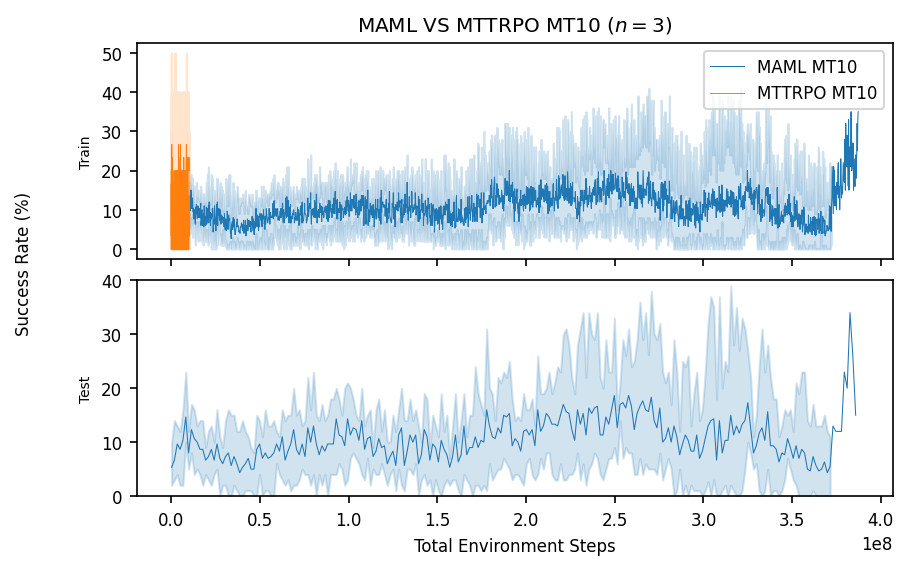

In [15]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.5,4), # use (6.5, 4) for single-column figures
                         tight_layout=True,
#                          gridspec_kw={'height_ratios': [3, 2], 'hspace': 0}
                         gridspec_kw={'hspace': 0.1}
                         )
train_ax, test_ax = axs

plot_data = {
    
    'MAML MT10': [
        'maml_trpo_metaworld_mt10_seed=1312_il=0.05_extra_tags=none',
        'maml_trpo_metaworld_mt10_seed=1483_il=0.05_extra_tags=none',
        'maml_trpo_metaworld_mt10_seed=674_il=0.05_extra_tags=none',
        
    ],
    'MTTRPO MT10': 
    [
        'mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
        'mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
        'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    ]

}

# Smoothing spans
smooth = {
    'MAML MT10': 3,
    'MTTRPO MT10': 1,
}

group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
#     dfs = [df.rolling(smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='SuccessRate', ax=train_ax, data=group_df, ci=99, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)
    if 'TestSuccessRate' in group_df.columns:
        group_df= group_df[group_df['TestSuccessRate'].notna()]
        sns.lineplot(x='TotalEnvSteps', y='TestSuccessRate', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                         color=train_color)

train_ax.set_title(r'MAML VS MTTRPO MT10 ($n=3$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
# train_ax.set_ylim([0, 10])
test_ax.set_ylabel('Test', fontsize='small')
test_ax.set_ylim([0, 40])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
# plt.xlim([0, 150e6])

In [8]:
fig1.show()
fig1.savefig('MTPPO-Pick-Place.png', pad_inches=0, dpi=300)